## 1. Importing libraries

In [1]:
import os
from docarray import Document, DocumentArray

## 2. Configuration and setup

In [2]:
MAX_DOCS = 100
DATA_DIR = 'data/images'
DATA_PATH = f"{DATA_DIR}/*/*.jpg"
QUERY_IMAGE = "data/query.jpg"

In [3]:
da = DocumentArray(storage='weaviate', config={'name': 'Image', 'host': 'localhost', 'port': '8080'})

da.summary()

       Documents Summary        
                                
  Length                 0      
  Homogenous Documents   False  
                                
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

## 3. Load Data

In [4]:
docs = da.from_files(DATA_PATH, size=MAX_DOCS, storage='weaviate', config={'name': 'Image', 'host': 'localhost', 'port': '8080'})
print(f"{len(docs)} Documents in DocumentArray")

100 Documents in DocumentArray


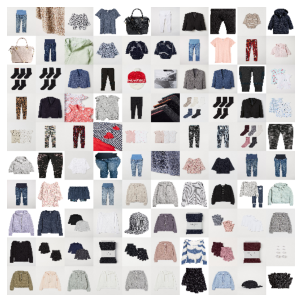

In [5]:
docs.plot_image_sprites() # Preview the images

## 4. Preprocess Data

In [6]:
# Convert to tensor, normalize so they're all similar enough
def preproc(d: Document):
    return (d.load_uri_to_image_tensor()  # load
             .set_image_tensor_shape((80, 60))  # ensure all images right size (dataset image size _should_ be (80, 60))
             .set_image_tensor_normalization()  # normalize color 
             .set_image_tensor_channel_axis(-1, 0))  # switch color axis for the PyTorch model later

In [7]:
# apply en masse
docs.apply(preproc)

                       Documents Summary                       
                                                               
  Length                 100                                   
  Homogenous Documents   True                                  
  Common Attributes      ('id', 'tensor', 'mime_type', 'uri')  
                                                               
                      Attributes Summary                       
                                                               
  Attribute   Data type      #Unique values   Has empty value  
 ───────────────────────────────────────────────────────────── 
  id          ('str',)       100              False            
  mime_type   ('str',)       1                False            
  tensor      ('ndarray',)   100              False            
  uri         ('str',)       100              False            
                                                               
           Storage Summary            
                                      
  Backend                  Weaviate   
  Host                     localhost  
  Port                     8080       
  Protocol                 http       
  Schema Name              Image      
  Serialization Protocol

## 5. Embed images

In [8]:
# Use GPU if available
import torch
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [9]:
import torchvision
model = torchvision.models.resnet50(pretrained=True)  # load ResNet50

In [10]:
docs.embed(model, device=device)    

KeyError: '7548b8bc-0486-51de-a97a-22f1b39ffd33'

<DocumentArrayWeaviate (length=100) at 4690088384>

## 6. Query dataset

In [ ]:
query_doc = Document(uri=QUERY_IMAGE)
query_doc.display()


In [ ]:
query_docs = DocumentArray([query_doc])

In [ ]:
query_docs.apply(preproc)

In [ ]:
query_docs.embed(model, device=device) # If running on non-gpu machine, change "cuda" to "cpu"

In [ ]:
query_docs.match(docs)

In [ ]:
(DocumentArray(query_doc.matches, copy=True)
    .apply(lambda d: d.set_image_tensor_channel_axis(0, -1)
                      .set_image_tensor_inv_normalization())).plot_image_sprites()